# Read Me
This script trains batches of GP's with user-specified structure and digitization options. The training hyperparameters were randomly sampled and a mixture of training strategies (e.g., data augmentation, random digitization etc.) were employed. The best model was selected by testing models on a grid of all possible parameter values.

In [1]:
import sys
import os
import argparse
import warnings 

import numpy as np
import pandas as pd
import torch
import gpytorch
from torch.utils.data import DataLoader, random_split
# from sklearn.preprocessing import MinMaxScaler, StandardScaler
import gpytorch
import plotly.express as px
import matplotlib.pyplot as plt
import wandb
# import optuna
sys.path.append('..')
sys.path.insert(0, '../src')

# custom imports
from model import GPModel
from grid import Grid
from minmaxscalertorch import MinMaxScalerTorch
from train_eval_plotter import prettyplot, vis_pred, vis_acq, plot_gp_res

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/valenetjong/opt/anaconda3/envs/nlp-m/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
""" Training and hyperparameter search configurations """

parser = argparse.ArgumentParser(description='Ferroelectric GP')
parser.add_argument('--grid_dim', type=int, default=30, 
                    help='number of test points per parameter (default: 30)')
parser.add_argument('--train_flag', type=bool, default=True, 
                    help='train or load pre-saved model (default: True)')
parser.add_argument('--matern_nu', type=float, default=0.5, 
                    help= "matern nu value (vals: 0.5, 1.5,or 2.5)")
parser.add_argument('--lengthscale_prior', type=list, default=[1.0, 1.0], 
                    help= "initial lengthscale value")
parser.add_argument('--train_flag_ls', type=bool, default=True, 
                    help= "train lengthscale (default: True)")
parser.add_argument('--min_ls', type=float, default=3e-2, 
                    help= "minimum lengthscale constraint (default: 5e-2)")
parser.add_argument('--epochs', type=int, default=3000, 
                    help='number of epochs to train (default: 2500)')
parser.add_argument('--lr', type=float, default=0.003, metavar='LR',
                    help='learning rate (default: 0.003)')
parser.add_argument('--seed', type=int, default=1,
                    help='random seed (default: 1)')
parser.add_argument('--gpus', default=0,
                    help='number gpus used for training - e.g 0,1,3')
parser.add_argument('--log-interval', type=int, default=500,
                    help='how many epochs to wait before logging training status')
parser.add_argument('--wandb', action='store_true', default=True, 
                    help='enables wandb logger')  
parser.add_argument("--mc_an_flag",type=str, default="mc", 
                    help= "mc or analytic acquisition (vals: 'mc', 'analytic')")
parser.add_argument("--acq_f",type=list, default=['qUCB', 'thompson'], 
                    help= "acq function list (vals: 'qEI', 'qPI', 'qUCB', 'thompson'")
parser.add_argument("--num_suggestions",type=int, default=4, 
                    help= "number of suggested points for mc acquisition")
args = parser.parse_args("")

# Set random seed to reproduce results
torch.manual_seed(args.seed)

## Data Read and Pre-processing

In [3]:
""" Helper functions for data loading and display """

def read_dat(dir="/Users/valenetjong/Bayesian-Optimization-Ferroelectrics/data/",
            src_file = "Bolometer_readings_PulseForge.xlsx", sheet= "Combined"):
    file = dir + src_file
    fe_data = pd.read_excel(file, sheet_name=sheet, usecols=['Energy density new cone (J/cm^2)',
                            'Time (ms)','2 Qsw/(U+|D|) 1e6cycles'])
    fe_data.dropna(subset=['2 Qsw/(U+|D|) 1e6cycles'], inplace=True)
    fe_data = fe_data[fe_data['2 Qsw/(U+|D|) 1e6cycles']!= 0]
    return fe_data

def display_data(fe_data):
    """
    [display_data(fe_data)] creates a cross-section scatter plot of all combinations
    of the four input parameters and single output parameter.
    """
    fig = px.scatter_matrix(fe_data, dimensions=['Energy density new cone (J/cm^2)', 
    "Time (ms)", "2 Qsw/(U+|D|) 1e6cycles"], color_discrete_sequence=["#72356c"]*23)
    fig.update_layout(template="ggplot2")
    fig.update_layout(width = 800, height=800)
    fig.show()

In [4]:
""" Create dataset """

def datasetmaker(fe_data, scaler):
    """
    [datasetmaker(fe_data, scaler)] filters and transforms the data in pandas df [fe_data] 
    into two tensors, [train_x] for input and [train_y] for output tensors. 
    """
    # filter training data 
    energy_den = fe_data['Energy density new cone (J/cm^2)'].values
    time = fe_data['Time (ms)'].values
    train_x = torch.Tensor(np.array([time, energy_den])).T
    train_y = torch.Tensor(fe_data['2 Qsw/(U+|D|) 1e6cycles'].values)

    # scale inputs
    train_x = scaler.fit_transform(train_x)
    return train_x, train_y

In [5]:
# Load dataset
fe_data = read_dat()
print(fe_data) # peep data
scaler =  MinMaxScalerTorch()
train_x, train_y = datasetmaker(fe_data, scaler)
num_params, num_samples = train_x.size(dim=1), train_x.size(dim=0)

# Create grid for grid search and evaluation
grid = Grid(train_x)
test_grid, test_arr = grid.test_grid, grid.test_arr

    Time (ms)  Energy density new cone (J/cm^2)  2 Qsw/(U+|D|) 1e6cycles
4        0.50                              2.73                 0.873026
5        0.50                              3.40                 2.677245
6        1.00                              3.79                 1.699015
7        1.00                              6.44                 3.805053
8        1.50                              5.36                 3.334856
9        1.50                              8.99                 4.535153
11       5.00                              8.80                 1.362510
13       5.00                             14.67                 3.841291
19       0.50                              5.24                 1.201357
22       5.00                             14.89                 3.513652
23       2.00                             10.13                 3.470871
24       0.50                              4.51                 0.263298
25       0.50                              5.37    

## GP Training and Eval

In [6]:
# Configure parameters for training

class Config():
    def __init__(self):
        self.epochs = args.epochs
        self.kernel = "matern"
        self.lr = args.lr
        self.dim = 2
        self.noise = 0.1

config = Config()

In [7]:
""" Helper functions for creating GP model """

def kernel_func(config_kernel, num_params, lscale):
    """
    [kernel_func(config_kernel, num_params, lscale)] returns kernel function with 
    dimensions specified by [num_params]. 
    """
    if config_kernel == "rbf":
        return gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=num_params))
    elif config_kernel == "matern":
        return gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(ard_num_dims=num_params, 
        lengthscale = torch.tensor(lscale), lengthscale_constraint = gpytorch.constraints.GreaterThan(args.min_ls), nu=args.matern_nu))

def make_model(train_x, train_y, num_params, config):
    """
    [make_model(train_x, train_y, num_params, config)] returns likelihood and 
    model with lengthscale, noise, kernel function specified by sweeps. 
    """
    
    lscale = args.lengthscale_prior
    kernel = kernel_func(config.kernel, num_params, lscale)
    
    print(kernel)
    num_samples = len(train_x)
    noise = config.noise*torch.ones(num_samples)
    likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=noise)
    model = GPModel(train_x, train_y, likelihood, kernel)

    return likelihood, model, lscale

In [8]:
""" Training and evaluation functions """ 

def train(train_x, train_y, num_params, config):
    likelihood, model, lscale = make_model(train_x, train_y, num_params, config)
    model.covar_module.base_kernel.lengthscale = torch.Tensor(lscale)
    training_iter = config.epochs
    if not args.train_flag_ls: # disallow training of lengthscale
        model.covar_module.base_kernel.raw_lengthscale.requires_grad_(False) 
    
    model.train(), likelihood.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    loss_lst = []

    for i in range(1, training_iter+1):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()

        if i==1 or i % 500 == 0: 
            print('Iter %d/%d - Loss: %.3f  lengthscale1: %s   noise: %s' % (
                    i, training_iter, loss.item(), 
                    model.covar_module.base_kernel.lengthscale.detach().numpy(),
                    model.likelihood.noise.detach().numpy()
                    )) 
            loss_lst.append(loss.item())
        optimizer.step()
        
    print(model.covar_module.outputscale.detach().numpy())
    return likelihood, model, loss_lst

def eval_mod(likelihood, model, test_arr):
    """ 
    [eval_mod(likelihood, model, test_arr)] evaluates GP model. 
    """
    model.eval(), likelihood.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        obs = likelihood(model(test_arr), noise=(torch.ones(len(test_arr))*config.noise))
    return obs

In [9]:
# set up dir for file search
cur_dir = os.getcwd()
par_dir = os.path.dirname(cur_dir)
model_dir = os.path.join(par_dir, 'models')

In [10]:
if args.train_flag:
    likelihood, model, loss_lst = train(train_x, train_y, num_params, config)
    torch.save({'model_state_dict': model.state_dict(), 'loss': loss_lst}, 
                model_dir + '/model_state.pth')

ScaleKernel(
  (base_kernel): MaternKernel(
    (raw_lengthscale_constraint): GreaterThan(3.000E-02)
  )
  (raw_outputscale_constraint): Positive()
)
Iter 1/3000 - Loss: 2.564  lengthscale1: [[1. 1.]]   noise: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1]
Iter 500/3000 - Loss: 1.639  lengthscale1: [[0.39287987 0.33076864]]   noise: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1]
Iter 1000/3000 - Loss: 1.417  lengthscale1: [[0.21365075 0.15103558]]   noise: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1]
Iter 1500/3000 - Loss: 1.385  lengthscale1: [[0.15172486 0.10724418]]   noise: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0

In [11]:
likelihood, model, _ = make_model(train_x, train_y, num_params, config)
saved_model = torch.load(model_dir + '/model_state.pth')
model.load_state_dict(saved_model['model_state_dict'])
loss_lst = saved_model['loss']
obs = eval_mod(likelihood, model, test_arr)

ScaleKernel(
  (base_kernel): MaternKernel(
    (raw_lengthscale_constraint): GreaterThan(3.000E-02)
  )
  (raw_outputscale_constraint): Positive()
)


### Visualize Training Results

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
     Metric  Value
0      RMSE  0.136
1       MAE  0.099
2  Spearman  0.971
3  R² score  0.983


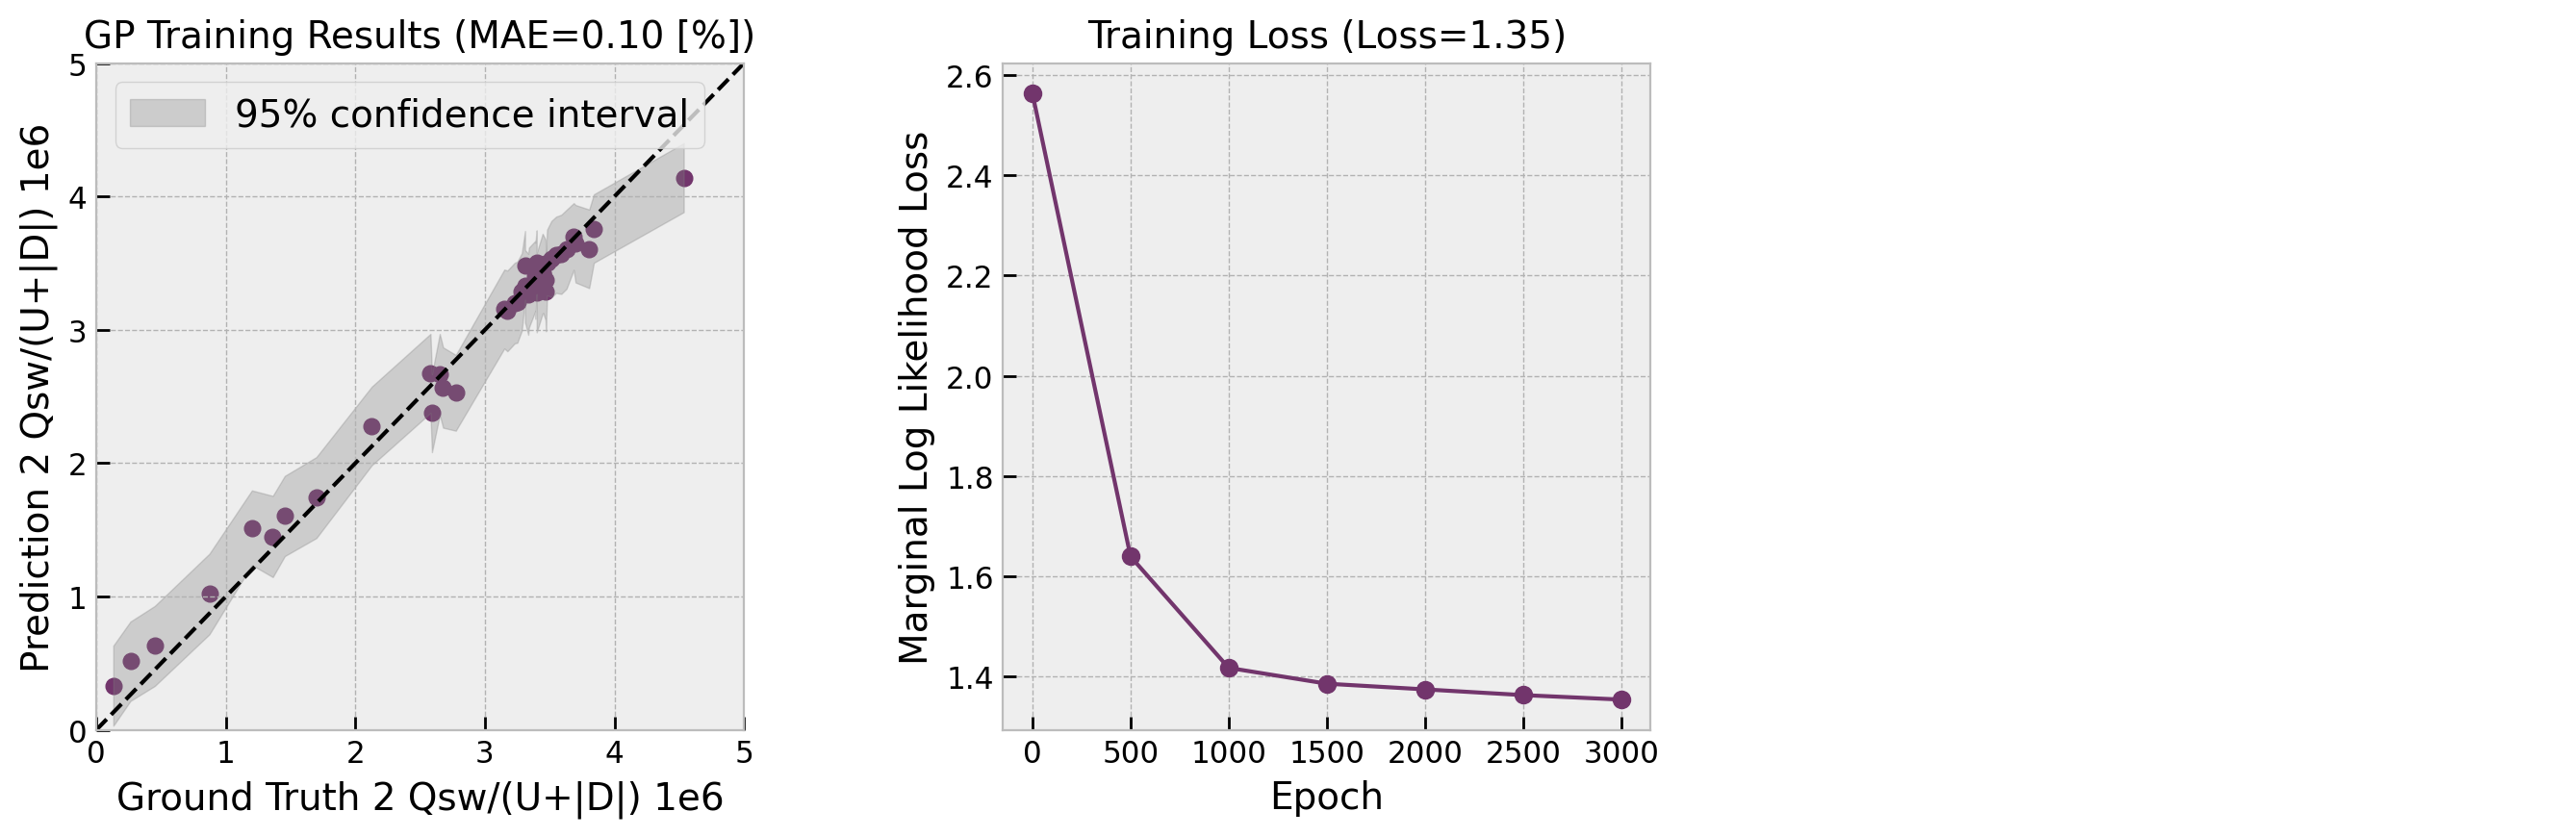

In [12]:
warnings.filterwarnings("ignore",  # suppress training warnings
                        category=gpytorch.utils.warnings.GPInputWarning)

model.eval(), likelihood.eval()
f_obj = model(train_x)
y_preds, f_var = likelihood(f_obj), f_obj.variance

with torch.no_grad(): y_preds_mean, f_var = y_preds.mean.numpy(), np.sqrt(f_var).numpy()
plot_gp_res(train_y, y_preds_mean, loss_lst, f_var)

In [13]:
# Analytic ax aquisition single suggestion EI, PI, UCB
from botorch.acquisition import ExpectedImprovement as EI
from botorch.acquisition import ProbabilityOfImprovement as PI
from botorch.acquisition import UpperConfidenceBound as UCB
from botorch.optim import optimize_acqf

scaled_bounds = torch.tensor([[0.0] * 2, [1.0] * 2]) # training data min-max scaled
y_max = train_y.max()
beta = 5
model.eval(), likelihood.eval()
q = 1

opt_acqf_config = lambda f_acq, q: optimize_acqf(f_acq, scaled_bounds, q, 
                num_restarts=20, raw_samples=args.grid_dim**2, options={},)[0]

def get_x_pred(acq_pt): return np.round(scaler.inverse_transform(acq_pt),2)

def get_y_pred_mean(acq_pt, q):
    y_pred_mean = likelihood(model(acq_pt)).mean.detach().numpy()
    return np.round(y_pred_mean.item(),2) if q==1 else np.round(y_pred_mean,2)

if args.mc_an_flag == "analytic": 
    f_acqs = [EI(model, y_max), PI(model, y_max), UCB(model, beta)]
    acqs_pts = [opt_acqf_config(f_acq, q) for f_acq in f_acqs]
    acqs_vals = [(get_x_pred(acq_pt), get_y_pred_mean(acq_pt, q)) for acq_pt in acqs_pts] 

    acqs = {k:v for k,v in zip(["EI", "PI", "UCB"], acqs_vals)}
    print(acqs)

In [14]:
# Monte Carlo ax aquisitions (qEI, qPI, qUCB)
from botorch.acquisition import qExpectedImprovement as qEI
from botorch.acquisition import qProbabilityOfImprovement as qPI 
from botorch.acquisition import qUpperConfidenceBound as qUCB
from botorch.sampling import SobolQMCNormalSampler

if args.mc_an_flag == "mc": 
    q = args.num_suggestions
    sampler = SobolQMCNormalSampler(sample_shape=torch.Size([1024]), seed=args.seed)

    # for each acq func, generate `q=4` candidates jointly using 20 random restarts
    # and args.grid_dim**2 raw samples
    f_acqs_mc = []
    if "qEI" in args.acq_f: 
        f_acqs_mc.append(qEI(model, y_max, sampler))
    if "qPI" in args.acq_f: 
        f_acqs_mc.append(qPI(model, y_max, sampler))
    if "qUCB" in args.acq_f: 
        f_acqs_mc.append(qUCB(model, beta, sampler))
    acqs_pts_mc = [opt_acqf_config(f_acq_mc, q) for f_acq_mc in f_acqs_mc]
    acqs_vals_mc = [(get_x_pred(acq_pt), get_y_pred_mean(acq_pt, q)) for acq_pt in acqs_pts_mc] 

    acqs_mc = {k:v for k,v in zip(args.acq_f, acqs_vals_mc)}
    print(acqs_mc)

{'qUCB': (array([[ 2.15, 12.29],
       [ 1.26, 11.21],
       [ 4.22, 14.06],
       [ 4.17, 15.44]]), array([2.79, 2.89, 2.84, 2.87], dtype=float32))}


In [15]:
from thompson import ThompsonSampling

if args.mc_an_flag == "mc" and "thompson" in args.acq_f: 
    q = args.num_suggestions
    batch_size = 1
    n_init = 1
    max_evals = args.num_suggestions*2
    n_cands = args.grid_dim**2

    thompson_args = {
        "n_init": n_init,
        "max_evals": max_evals,
        "batch_size": batch_size,
        "n_cands": n_cands
    }

    thompson = ThompsonSampling(model, likelihood, scaler, args.seed)
    X_ciq, Y_ciq = thompson.run_optimization(**thompson_args)
    print(X_ciq, Y_ciq)
    acqs_mc["thompson"] = (np.array(X_ciq), Y_ciq.detach().numpy())
    # X_lanczos, Y_lanczos = thompson.run_optimization(**thompson_args, sampler="lanczos")

1) Best value: 2.62e+00
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Inte

In [16]:
# export predictions to csv
def pred_to_csv(acqs, file_out="preds.csv"):
    """
    [pred_to_csv(acqs, file_out)] outputs suggested inputs and their respective 
    predicted outputs to csv.
    """   
    dir = "/Users/valenetjong/Bayesian-Optimization-Ferroelectrics/predictions/"
    file = open(dir + file_out, "w", encoding="utf-8")
    acq_data = {'Acq':[], 'Time (ms)':[], 'Energy density new cone (J/cm^2)':[], '2 Qsw/(U+|D|) 1e6':[]}

    for lab, vals in acqs.items():
        for i in range(args.num_suggestions):
            time_val = vals[0][i][0]
            energy_den_val = vals[0][i][1]
            fig_of_merit = vals[1][i]
            acq_data["Acq"].append(lab)
            acq_data['Time (ms)'].append(time_val)
            acq_data['Energy density new cone (J/cm^2)'].append(energy_den_val)
            acq_data['2 Qsw/(U+|D|) 1e6'].append(fig_of_merit)        

    df = pd.DataFrame(acq_data)
    df.to_csv(file, index=False)
    return df

### Save Predictions and Visualize 

In [17]:
# get normalized suggestions
nshape = (args.grid_dim, args.grid_dim)
transpose = lambda tensor: tensor.detach().numpy().reshape(nshape).T
lower, upper = obs.confidence_region()
upper_surf, lower_surf = transpose(upper), transpose(lower)
pred_labels = obs.mean.view(nshape).T

# save to csv, get suggested points
acq_df = pred_to_csv(acqs_mc)

In [18]:
print(acq_df)

        Acq  Time (ms)  Energy density new cone (J/cm^2)  2 Qsw/(U+|D|) 1e6
0      qUCB       2.15                             12.29               2.79
1      qUCB       1.26                             11.21               2.89
2      qUCB       4.22                             14.06               2.84
3      qUCB       4.17                             15.44               2.87
4  thompson       1.70                              7.33               2.62
5  thompson       2.21                             12.79               2.70
6  thompson       3.88                             11.93               2.57
7  thompson       4.00                             10.85               2.54


In [19]:
import plotly.graph_objects as go
def vis_acq(train_x, train_y, test_grid, pred_labels, upper_surf, lower_surf, acqs):
    fig = go.Figure(data=[go.Surface(z=pred_labels.numpy(), 
                                    x=test_grid[:,0],
                                    y=test_grid[:,1],
                                    opacity = 0.8,
                                    colorscale = "Burg",
                                    colorbar=dict(thickness=15, len=0.5),
                                    name='GP regression')])

    fig.add_trace(go.Surface(z=upper_surf, x=test_grid[:,0],
                    y=test_grid[:,1], opacity=0.2, colorscale = "Burg", showscale=False))

    fig.add_trace(go.Surface(z=lower_surf, x=test_grid[:,0],
                            y=test_grid[:,1], 
                            colorscale = "Burg",
                            opacity=0.2, showscale=False))
    fig.add_trace(go.Scatter3d(x=train_x[:,0], 
                                y=train_x[:,1], 
                                z=train_y.numpy(), 
                                mode='markers', 
                                name='training data', 
                                marker={'color':'#72356c'}))

    for acq_name, vals in acqs.items():
        time_list, energy_den_list, fom_list = [], [], []
        for i in range(args.num_suggestions):
            time_list.append(vals[0][i][0])
            energy_den_list.append(vals[0][i][1])
            fom_list.append(vals[1][i])
        fig.add_trace(go.Scatter3d(x=time_list, 
                                y=energy_den_list,
                                z=fom_list, mode='markers', 
                                name= acq_name)) 

    fig.update_layout(width=1200, height=750,
                    margin=dict(r=20, l=10, b=15, t=10),
                    legend=dict(orientation="h", yanchor="bottom", 
                                y=0.9, xanchor="right",x=0.75),
                    scene=dict(
                        xaxis_title="Pulse Width (msec)",
                        yaxis_title="Energy density new cone (J/cm^2)",
                        zaxis_title='2 Qsw/(U+|D|) 1e6')
                    )

    fig.update_layout(template="ggplot2")
    camera = dict(up=dict(x=0, y=0, z=1), center=dict(x=0, y=0, z=0),
                    eye=dict(x=2, y=0.9, z=0.7))

    fig.update_layout(scene_camera=camera)

    fig.show()

In [20]:
raw_train_x, raw_test_grid = scaler.inverse_transform(train_x), scaler.inverse_transform(test_grid) # undo scaling
vis_acq(raw_train_x, train_y, raw_test_grid, pred_labels, upper_surf, lower_surf, acqs_mc)